In [ ]:
#lasio is required to convert data from las to xlsx format
!pip install lasio

In [ ]:
#Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [ ]:
#Convert the data from las to xlsx
las = lasio.read(r'/content/f02a03s2_20030103-1-04_RWD.LAS')
las.to_excel('D2.xlsx')


In [ ]:
#Convert the data from xlsx to dataframe

data_df = pd.read_excel('D2.xlsx',sheet_name =1)  #for different data edit the csv name
D11 = pd.DataFrame(data_df)
data_df.head(-20)


,DEPT,BDCM,DRHM,GRAM,NPLM,RACHM,RACLM,RPCHM,RPCLM,TCDMDIR
0,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1600.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1600.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1600.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1600.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3275,1927.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3276,1927.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277,1927.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3278,1927.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


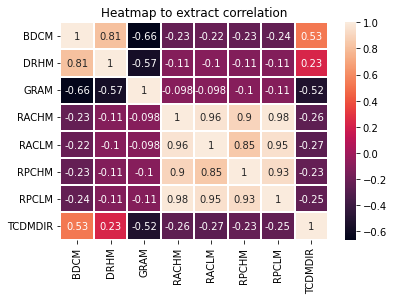

In [ ]:
#Heatmap created to eliminate the feature that have high correlation amongst each other

hm = data_df.drop(['DEPT', 'NPLM'],axis =1)

ax = plt.axes()
sns.heatmap(hm.corr(),linewidths=1,annot = True)
ax.set(title = "Heatmap to extract correlation")
plt.show()

In [ ]:
# Read & define the dataset required and some data cleaning

D1  = pd.DataFrame(D11.iloc[:,1:7])
D1  = D1.dropna()
D1  = D1.reset_index(drop=True)
D1x = D1.loc[: , ['BDCM', 'GRAM', 'RACLM']].copy()
D1y = pd.DataFrame(D1['NPLM'])/100
D1y = D1y.clip(lower = float(0))
D1x

,BDCM,GRAM,RACLM
0,1.150,94.597,0.418
1,1.185,93.638,0.417
2,1.219,92.679,0.416
3,1.254,91.720,0.415
4,1.288,90.761,0.417
...,...,...,...
3155,2.212,94.667,0.508
3156,2.192,92.916,0.501
3157,2.190,96.265,0.486
3158,2.200,92.588,0.467


In [ ]:
#Scaling the features' data using MinMaxScaler for better training of the models

sc_data = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc_data.fit_transform(D1x)
tt = pd.DataFrame((training_set_scaled))
training_data = pd.concat([tt,D1y],axis=1)  #print(type(D1c))  #D1c = D1x.append(D1y)  #D1y.min()
training_data          #D1x.max()      #train.max()   #len(training_data)


,0,1,2,NPLM
0,0.000000,0.698167,0.002836,0.47921
1,0.023973,0.687901,0.002820,0.51096
2,0.047260,0.677636,0.002805,0.54271
3,0.071233,0.667370,0.002789,0.57447
4,0.094521,0.657104,0.002820,0.60622
...,...,...,...,...
3155,0.727397,0.698917,0.004238,0.43628
3156,0.713699,0.680173,0.004129,0.42584
3157,0.712329,0.716023,0.003896,0.43662
3158,0.719178,0.676661,0.003600,0.43747


In [ ]:
#Split the data into test and train dataset
X_train, X_test, y_train, y_test = train_test_split( training_data.iloc[:,:-1], training_data.iloc[:,-1], test_size=0.33, shuffle=False)
#print(training_data.iloc[:,:-1], training_data.iloc[:,-1],'\n')
print('\n', X_test,y_test) #X_train, y_train,
type(y_train)


              0         1         2
2117  0.827397  0.271377  0.002322
2118  0.818493  0.165250  0.002306
2119  0.808904  0.143038  0.002291
2120  0.803425  0.222221  0.002291
2121  0.804795  0.202984  0.002291
...        ...       ...       ...
3155  0.727397  0.698917  0.004238
3156  0.713699  0.680173  0.004129
3157  0.712329  0.716023  0.003896
3158  0.719178  0.676661  0.003600
3159  0.724658  0.694410  0.003381

[1043 rows x 3 columns] 2117    0.19523
2118    0.20472
2119    0.21624
2120    0.23253
2121    0.19818
         ...   
3155    0.43628
3156    0.42584
3157    0.43662
3158    0.43747
3159    0.42487
Name: NPLM, Length: 1043, dtype: float64


pandas.core.series.Series

In [ ]:
#Splitting data into time steps because RNN, LSTM and GRU model need data that is divided by time steps
#As per the time steps our model will have the "memory" of the time series data

X_train_ts ,y_train_ts,X_test_ts ,y_test_ts = [],[],[],[]

#vary the no. of time steps in order to tune the model
ls = 4  #time steps

#For training data
for i in range(ls, (X_train.shape[0])): # upper bound is number of values
  X_train_ts.append(X_train.iloc[(i-ls):i, :]) # takes ls previous values from 'ls' past values
  y_train_ts.append(y_train[i-ls]) #contains values learned to predict  #print(len(X_train))

#For test data
for j in range(X_train.shape[0]+ls, training_data.shape[0]):
  #print(j-ls,j)
  X_test_ts.append(X_test.loc[(j-ls):j-1, :])
  y_test_ts.append(y_test[j-ls])

X_train_ts, y_train_ts = np.array(X_train_ts), np.array(y_train_ts)
X_test_ts,  y_test_ts  = np.array(X_test_ts),  np.array(y_test_ts )  #print(X_train_ts,y_train_ts) #X_test_ts


In [ ]:
#Building LSTM Model:

#Here, you can vary the no. of layers and no. of units in each layer for hyper parameter tuning

#First layer
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train_ts.shape[1],X_train_ts.shape[2])))
regressor.add(Dropout(0.2))

#Second layer
#regressor.add(LSTM(units = 16, return_sequences = False))
#regressor.add(Dropout(0.2))

#Third layer
#regressor.add(LSTM(units = 8, return_sequences = True))
#regressor.add(Dropout(0.2))

#Fourth layer
#regressor.add(LSTM(units = 2, return_sequences = False))
#regressor.add(Dropout(0.2))

#Final Dense layer
regressor.add(Dense(1))

#Cost Function and Optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.001) #Here you can vary the learning rate
regressor.compile(optimizer = opt, loss = 'mean_squared_error',  )
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10800     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the model
#Here you can vary the batch size and no. of epoch for how long you want model to be trained
history = regressor.fit(X_train_ts, y_train_ts, validation_split = 0.2, epochs = 80, batch_size = 32, verbose = 1)

Epoch 1/80
53/53 [==============================] - 3s 15ms/step - loss: 0.0288 - val_loss: 0.0033
Epoch 2/80
53/53 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 9.9524e-04
Epoch 3/80
53/53 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 9.1706e-04
Epoch 4/80
53/53 [==============================] - 0s 5ms/step - loss: 0.0080 - val_loss: 8.8849e-04
Epoch 5/80
53/53 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 8.3341e-04
Epoch 6/80
53/53 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 8.0933e-04
Epoch 7/80
53/53 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 8/80
53/53 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 9.2332e-04
Epoch 9/80
53/53 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 7.5890e-04
Epoch 10/80
53/53 [==============================] - 0s 6ms/step - loss: 0.0065 - val_los

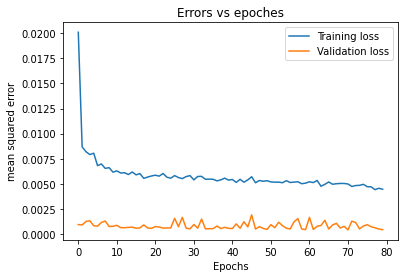

In [ ]:
#Error v/s Epochs to study the improvement of the model
ax = plt.axes()
ax.set(title = "Errors vs epoches", xlabel = "Epochs", ylabel = "mean squared error")
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()

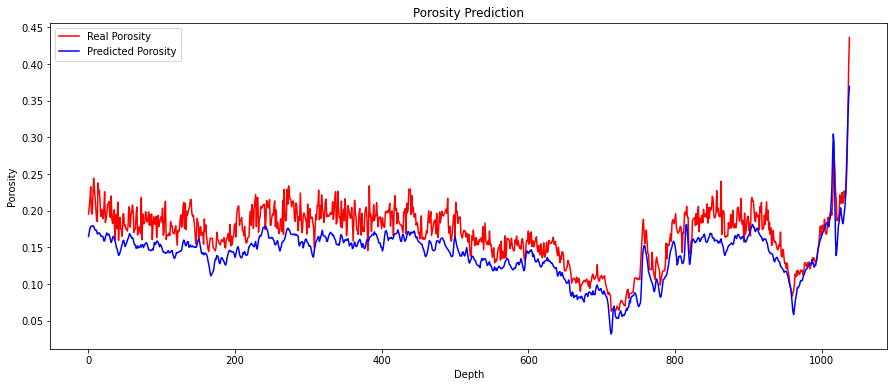

In [ ]:
real_por = y_test_ts
predicted_por = regressor.predict(X_test_ts)

# Visualising the results of the test and predicted data
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(predicted_por, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()

In [ ]:
# Visualising the results of test error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(real_por,predicted_por))

0.0009851929389194476


In [ ]:
#Building GRU Model:
#Here, you can vary the no. of layers and no. of units in each layer for hyper parameter tuning

#First layer
regressor_GRU = Sequential()
regressor_GRU.add(GRU(units = 50, return_sequences = False, input_shape = (X_train_ts.shape[1],X_train_ts.shape[2])))
#regressor_GRU.add(Dropout(0.2))

#Second layer
#regressor_GRU.add(GRU(units = 16, return_sequences = True))
#regressor_GRU.add(Dropout(0.2))

#Third layer
#regressor_GRU.add(GRU(units = 8, return_sequences = True))
#regressor_GRU.add(Dropout(0.2))

#Fourth layer
#regressor_GRU.add(GRU(units = 2, return_sequences = False))
#regressor_GRU.add(Dropout(0.2))

#Final Dense layer
regressor_GRU.add(Dense(1))

#Cost Function and Optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.001) #Here you can vary the learning rate
regressor_GRU.compile(optimizer = opt, loss = 'mean_squared_error',  )
regressor_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8250      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the model
#Here you can vary the batch size and no. of epoch for how long you want model to be trained

history_GRU = regressor_GRU.fit(X_train_ts, y_train_ts, validation_split = 0.2, epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
53/53 [==============================] - 3s 14ms/step - loss: 0.0305 - val_loss: 0.0026
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 9.8825e-04
Epoch 3/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0010
Epoch 4/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 9.4366e-04
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0010
Epoch 6/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 8.4777e-04
Epoch 7/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 8.5527e-04
Epoch 8/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 9.5776e-04
Epoch 9/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 9.1844e-04
Epoch 10/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 7

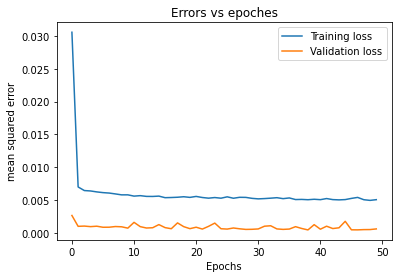

In [ ]:
#Error v/s Epochs to study the improvement of the model
ax = plt.axes()
ax.set(title = "Errors vs epoches", xlabel = "Epochs", ylabel = "mean squared error")
plt.plot(history_GRU.history['loss'], label='Training loss')
plt.plot(history_GRU.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()

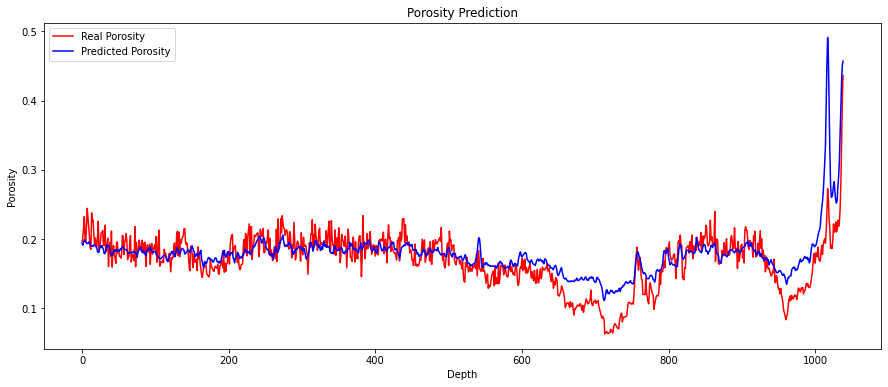

In [ ]:
# Visualising the results of the test and predicted data
predicted_por_GRU = regressor_GRU.predict(X_test_ts)
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(predicted_por_GRU, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()

In [ ]:
# Visualising the results of test error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(real_por,predicted_por_GRU))

In [ ]:
#Building SimpleRNN Model:
#Here, you can vary the no. of layers and no. of units in each layer for hyper parameter tuning

#First layer
regressor_SimpleRNN = Sequential()
regressor_SimpleRNN.add(SimpleRNN(units = 50, return_sequences = False, input_shape = (X_train_ts.shape[1],X_train_ts.shape[2])))
#regressor_SimpleRNN.add(Dropout(0.2))

#Second layer
#regressor_SimpleRNN.add(SimpleRNN(units = 16, return_sequences = True))
#regressor_SimpleRNN.add(Dropout(0.2))

#Third layer
#regressor_SimpleRNN.add(SimpleRNN(units = 8, return_sequences = True))
#regressor_SimpleRNN.add(Dropout(0.2))

#Fourth layer
#regressor_SimpleRNN.add(SimpleRNN(units = 2, return_sequences = False))
#regressor_SimpleRNN.add(Dropout(0.2))

#Final Dense layer
regressor_SimpleRNN.add(Dense(1))

#Cost Function and Optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.0001) #Here you can vary the learning rate
regressor_SimpleRNN.compile(optimizer = opt, loss = 'mean_squared_error',  )
regressor_SimpleRNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2700      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the model
#Here you can vary the batch size and no. of epoch for how long you want model to be trained

history_SimpleRNN = regressor_SimpleRNN.fit(X_train_ts, y_train_ts, validation_split = 0.2, epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
53/53 [==============================] - 1s 8ms/step - loss: 0.1126 - val_loss: 0.0186
Epoch 2/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0043
Epoch 3/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0021
Epoch 4/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0014
Epoch 5/50
53/53 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0015
Epoch 6/50
53/53 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 7/50
53/53 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 8/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 9/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 10/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 11/50
53/53 [

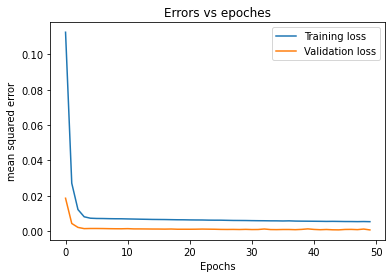

In [ ]:
#Error v/s Epochs to study the improvement of the model
ax = plt.axes()
ax.set(title = "Errors vs epoches", xlabel = "Epochs", ylabel = "mean squared error")
plt.plot(history_SimpleRNN.history['loss'], label='Training loss')
plt.plot(history_SimpleRNN.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()

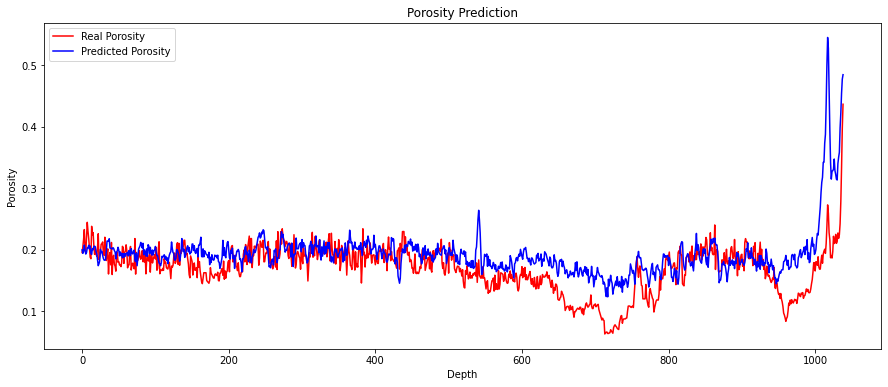

In [ ]:
# Visualising the results of the test and predicted data
predicted_por_SimpleRNN = regressor_SimpleRNN.predict(X_test_ts)
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(predicted_por_SimpleRNN, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()

In [ ]:
# Visualising the results of test error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(real_por,predicted_por_SimpleRNN))

0.004863033658507391
0.0011288421006992878


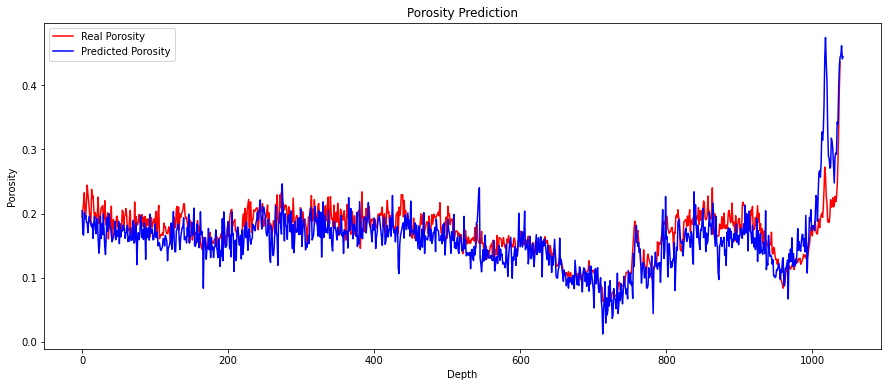

In [ ]:
#Building Linear Regression Model:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr_train = lr.predict(X_train)
y_pred_lr_test  = lr.predict(X_test)
print(mean_squared_error(y_train,y_pred_lr_train) )
print(mean_squared_error(y_test,y_pred_lr_test)   )


# Plot of test data with prediction
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(y_pred_lr_test, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()
#The two output values printed are training and test error


0.004864940983223457
0.001119436501950989


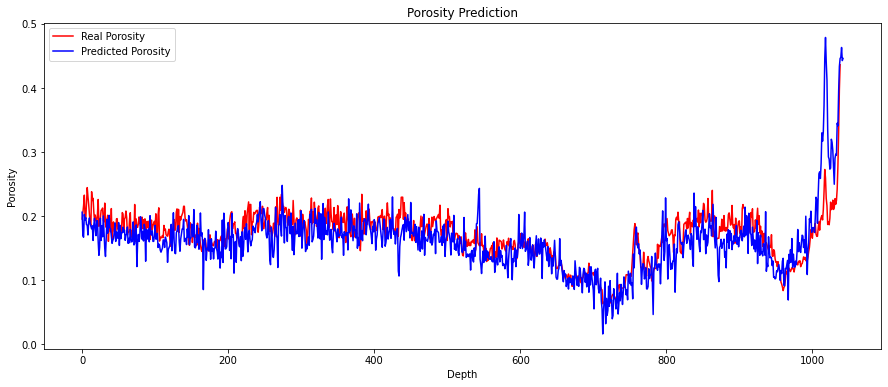

In [ ]:
#Building Lasso Model:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
ls = Lasso(alpha=0.0001)
ls.fit(X_train,y_train)
y_pred_ls_train = ls.predict(X_train)
y_pred_ls_test  = ls.predict(X_test)
print(mean_squared_error(y_train,y_pred_ls_train) )
print(mean_squared_error(y_test, y_pred_ls_test )   )


# Plot of test data with prediction
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(y_pred_ls_test, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()
#Also the two output values printed are training and test error

0.00323801154227425
0.00237331395366115


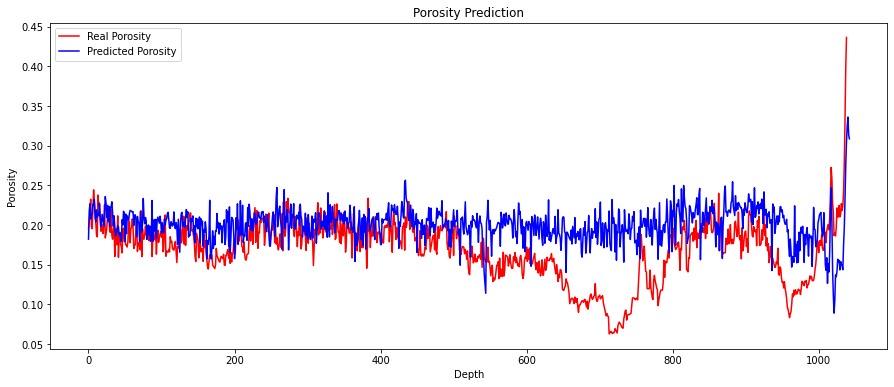

In [ ]:
#Building SVR Model:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
svr = SVR()
svr.fit(X_train,y_train)
y_pred_svr_train = svr.predict(X_train)
y_pred_svr_test  = svr.predict(X_test)
print(mean_squared_error(y_train,y_pred_svr_train) )
print(mean_squared_error(y_test,y_pred_svr_test)   )


# Plot of test data with prediction
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(y_pred_svr_test, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()
#Also the two output values printed are training and test error

0.0009428157010592151
0.0013432864001148665


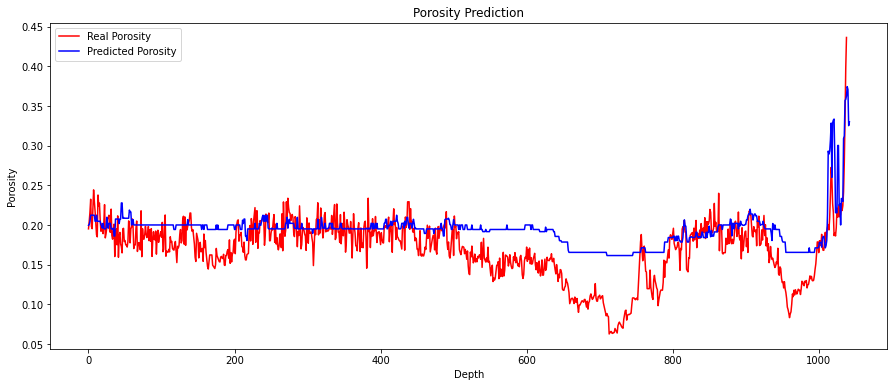

In [ ]:
#Building GBR Model:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)
y_pred_gbr_train = gbr.predict(X_train)
y_pred_gbr_test  = gbr.predict(X_test)
print(mean_squared_error(y_train,y_pred_gbr_train) )
print(mean_squared_error(y_test,y_pred_gbr_test) )

# Plot of test data with prediction
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(y_pred_gbr_test, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()
#Also the two output values printed are training and test error

[09:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.00011188799895396873
0.0036648971411365615


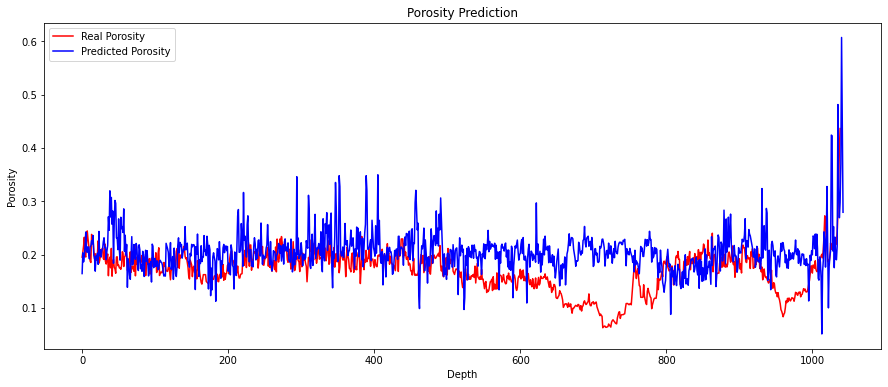

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.05, max_depth = 15, alpha = 10, n_estimators = 500)
xg_reg.fit(X_train,y_train)
y_pred_xg_reg_train = xg_reg.predict(X_train)
y_pred_xg_reg_test = xg_reg.predict(X_test)
print(mean_squared_error(y_train,y_pred_xg_reg_train) )
print(mean_squared_error(y_test,y_pred_xg_reg_test) )

# Plot of test data with prediction
plt.figure(figsize=(15,6))
plt.plot(real_por, color = 'red', label = 'Real Porosity')
plt.plot(y_pred_xg_reg_test, color = 'blue', label = 'Predicted Porosity')
plt.title('Porosity Prediction')
plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.legend()
plt.show()

#Also the two output values printed are training and test error